In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import librosa as lr
from glob import glob

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge

# Time Series Primer

Any dataset that changes with respect to time can be considered time series. Time Series Data needs at least two: 
- An array of data with the data itself. 
- An array with time associated for each data point.

In [3]:
price_data = pd.read_csv('/Users/Dillon/OneDrive/Documents/DataCampML/prices.csv')
price_data.head()

,date,symbol,close,volume
0,2010-01-04,AAPL,214.009998,123432400.0
1,2010-01-04,ABT,54.459951,10829000.0
2,2010-01-04,AIG,29.889999,7750900.0
3,2010-01-04,AMAT,14.300000,18615100.0
4,2010-01-04,ARNC,16.650013,11512100.0


<AxesSubplot:xlabel='date'>

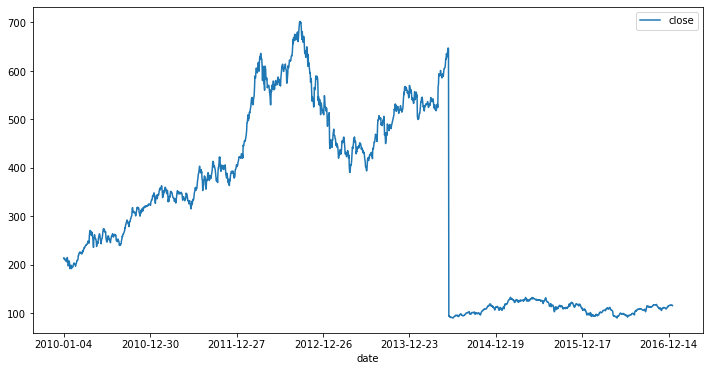

In [4]:
fig, ax = plt.subplots(figsize = (12, 6))
aapl = price_data[price_data['symbol'] == 'AAPL']
aapl.plot('date', 'close', ax = ax)

In [5]:
# To convert to datetime
price_data['date'] = pd.to_datetime(price_data['date'])

In [6]:
# To extract the month
price_data['Month'] = price_data['date'].dt.month

In [7]:
price_data.head()

,date,symbol,close,volume,Month
0,2010-01-04,AAPL,214.009998,123432400.0,1
1,2010-01-04,ABT,54.459951,10829000.0,1
2,2010-01-04,AIG,29.889999,7750900.0,1
3,2010-01-04,AMAT,14.300000,18615100.0,1
4,2010-01-04,ARNC,16.650013,11512100.0,1


In [8]:
audio_files = glob('/Users/Dillon/OneDrive/Documents/DataCampML/Audio/set_a')
audio, sfreq = lr.load('/Users/Dillon/OneDrive/Documents/DataCampML/Audio/set_a/artifact__201012172012.wav')

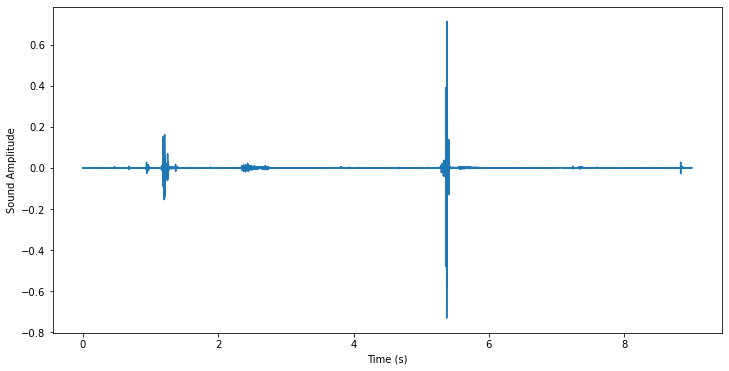

In [9]:
time = np.arange(0, len(audio))/sfreq
fig, ax = plt.subplots(figsize = (12, 6))
ax.set(xlabel = 'Time (s)', ylabel = 'Sound Amplitude')
ax.plot(time, audio)
plt.show()

# Time Series as Inputs to a Model

Need to perform feature extraction as raw audio data is too noisy. 
- Summary Statistics

In [10]:
set_a = pd.read_csv('/Users/Dillon/OneDrive/Documents/DataCampML/Audio/set_a.csv')

In [11]:
murmur_normal = set_a[set_a['label'].isin(['murmur', 'normal'])]

## Summary Statistics

In [38]:
audios = []
times = []
for file in murmur_normal['fname']:
        audio, sfreq = lr.load('/Users/Dillon/OneDrive/Documents/DataCampML/Audio/' + file)
        if len(audio) == 174979:
                ixs = np.arange(audio.shape[-1])
                time = ixs/sfreq
                audios.append(audio)
                times.append(time)

In [39]:
lens = []
for i in audios:
    lens.append(len(i))

np.mean(lens)

174979.0

In [40]:
time = times[0]
time

array([0.00000000e+00, 4.53514739e-05, 9.07029478e-05, ...,
       7.93541950e+00, 7.93546485e+00, 7.93551020e+00])

In [43]:
df = pd.DataFrame(data = audios, columns = time)
df.shape

(27, 174979)

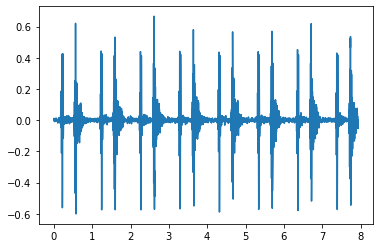

In [42]:
plt.plot(times[0], audios[0])
plt.show()

In [15]:
def summary(data):
    summary_stats = []
    
    for file in data['fname']:
        audio, sfreq = lr.load('/Users/Dillon/OneDrive/Documents/DataCampML/Audio/' + file)
        means = np.mean(audio, axis = -1)
        maxs = np.max(audio, axis = -1)
        stds = np.std(audio, axis = -1)
        s_stats = [means, maxs, stds]
        summary_stats.append(s_stats)

    return summary_stats, sfreq

In [16]:
X, sfreq = summary(murmur_normal)
y = murmur_normal['label'].reset_index(drop = True)

In [17]:
normal_X = X[34:]
murmur_X = X[:34]

In [18]:
normal_means = []
for i in normal_X:
    normal_means.append(i[0])

murmur_means = []
for i in murmur_X:
    murmur_means.append(i[0])

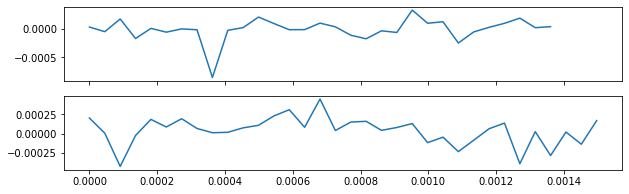

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 3), sharex = True)
ax1.plot(np.arange(0, len(normal_means))/sfreq, normal_means)
ax2.plot(np.arange(0, len(murmur_means))/sfreq, murmur_means)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)


In [21]:
model = LinearSVC()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6470588235294118

# Predicting Time Series Data

In [54]:
ebay = price_data[price_data['symbol'] == 'EBAY']
yahoo = price_data[price_data['symbol'] == 'YHOO']

In [76]:
prices = pd.merge(ebay, yahoo, on = 'date', suffixes = ('_ebay', '_yahoo'))
prices['date'] = pd.to_datetime(prices['date'])
prices.head()

,date,symbol_ebay,close_ebay,volume_ebay,Month_ebay,symbol_yahoo,close_yahoo,volume_yahoo,Month_yahoo
0,2010-01-04,EBAY,23.900000,22511600.0,1,YHOO,17.100000,16587400.0,1
1,2010-01-05,EBAY,23.650000,26683100.0,1,YHOO,17.230000,11718100.0,1
2,2010-01-06,EBAY,23.500000,26368600.0,1,YHOO,17.170000,16422000.0,1
3,2010-01-07,EBAY,23.229998,25220000.0,1,YHOO,16.700001,31816300.0,1
4,2010-01-08,EBAY,23.509999,30484000.0,1,YHOO,16.700001,15470000.0,1


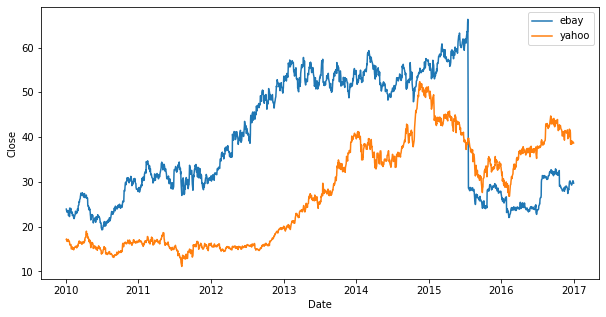

In [87]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot('date', 'close_ebay', data = prices, label = 'ebay')
plt.plot('date', 'close_yahoo', data = prices, label = 'yahoo')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

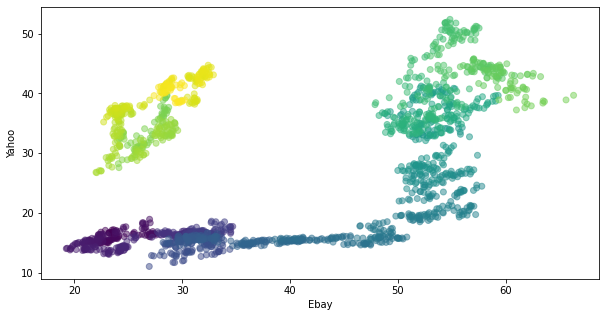

In [97]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.scatter(prices['close_ebay'], prices['close_yahoo'], c = prices.index, cmap = plt.cm.viridis, alpha = 0.5)
plt.xlabel('Ebay')
plt.ylabel('Yahoo')
plt.show()

## Predicting AAPL stock price

In [98]:
tech_prices = price_data[price_data['symbol'].isin(['AAPL', 'NVDA', 'EBAY', 'YHOO'])]

In [102]:
tech = tech_prices.pivot_table(values = 'close', index = pd.to_datetime(tech_prices['date']), columns = 'symbol')

In [155]:
X = tech[['NVDA', 'YHOO', 'EBAY']]
y = tech[['AAPL']]

In [156]:
scores = cross_val_score(Ridge(), X, y, cv = 5)
scores # Not the best scores

array([-3.79519169e+00,  6.88754904e-02, -9.39666910e+00, -1.71517506e+00,
       -3.28621454e+03])

In [157]:
npX = X.reset_index()
npy = y.reset_index()

In [159]:
npX = npX.loc[:,'NVDA':].to_numpy()
npy = npy.loc[:,'AAPL'].to_numpy()

In [168]:
X_train, X_test, y_train, y_test = train_test_split(npX, npy)

model = Ridge()
model.fit(X_train, y_train)
preds = model.predict(X_test)

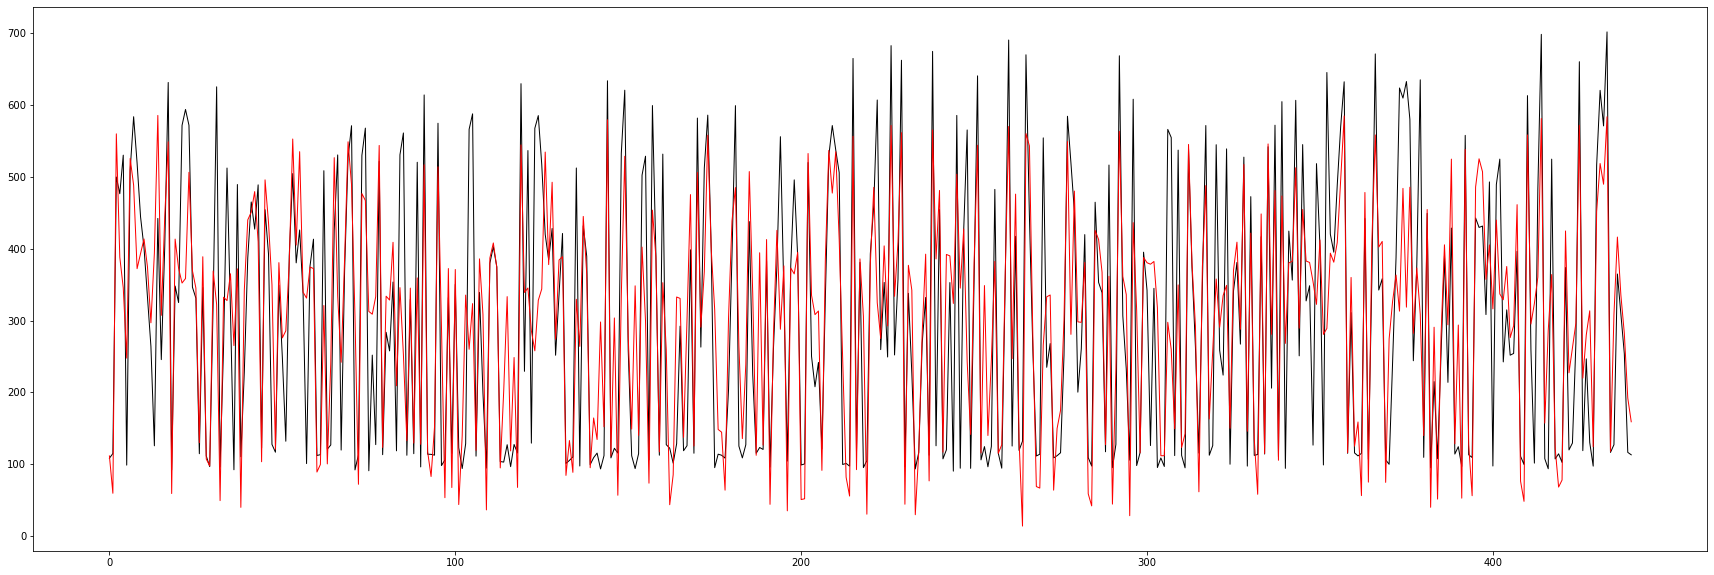

In [174]:
fig, ax = plt.subplots(figsize = (30, 10))
ax.plot(y_test, color = 'k', lw = 1)
ax.plot(preds, color = 'r', lw = 1)
plt.show()

## Feature Extratction

In [177]:
features_to_calc = [np.min, np.max, np.mean, np.std]
rolling_prices = y.rolling(20, min_periods=5, closed = 'right')
features = rolling_prices.aggregate(features_to_calc)

In [178]:
features

AAPL                                  
                  amin        amax        mean       std
date                                                    
2010-01-04         NaN         NaN         NaN       NaN
2010-01-05         NaN         NaN         NaN       NaN
2010-01-06         NaN         NaN         NaN       NaN
2010-01-07         NaN         NaN         NaN       NaN
2010-01-08  210.580000  214.379993  212.383998  1.735288
...                ...         ...         ...       ...
2016-12-23  109.110001  117.059998  113.401500  2.849479
2016-12-27  109.110001  117.260002  113.686000  2.939619
2016-12-28  109.110001  117.260002  113.951000  2.967152
2016-12-29  109.110001  117.260002  114.261500  2.913658
2016-12-30  109.110001  117.260002  114.578000  2.704352

[1762 rows x 4 columns]

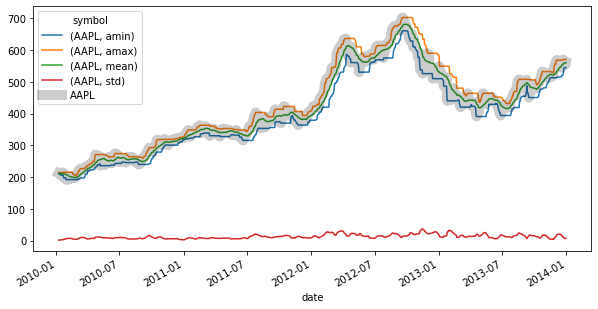

In [196]:
fig, ax = plt.subplots(figsize=(10, 5))
features.loc['2010-01-08':'2014-01-01'].plot(ax = ax)
y.loc['2010-01-08':'2014-01-01'].plot(ax = ax,color = 'k', alpha = .2, lw = 10)
plt.show()